Name: Gurjeet Singh

#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [ ]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

**Answer**

By varying the ECONDING_DIM we change the dimensionality of the unitary matrix $U$ retrieved by the $SVD$ Decomposition computed on the covariance matrix.
Note that the returned $U$ matrix from the linalg.SVD function is square matrix since the covariance matrix is symmetric.
In particular we take the first k (which correspond to our ENCODING_DIM value variable) orthonormal vectors of the matrix U, hence we have that: $U_K = [U_1 .... U_i] \quad where \quad i = 1,.., k \implies U_K \in \mathbb{R}^{784 \times 120 } $.

By defining ENCODING_DIM less than our 784 original features of the covariance matrix we end up having a $U$ with the **only** first $k$ **principal directions**. 

Thus by computing $X_{train} \cdot U_K$ we project the data on the first $k$ principal directions, resulting in a Principal Component matrix made of **$k$ features space**. <br/> **Hence we describe/compress** our data in a lower **feature space** taking in account the decomposition of the covariance matrix based on maximum variance direction.

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

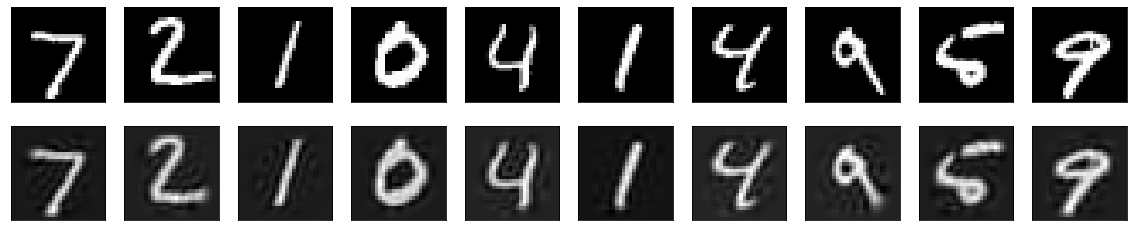

In [ ]:
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 4s 5ms/step - loss: 0.0425 - val_loss: 0.0143
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00477


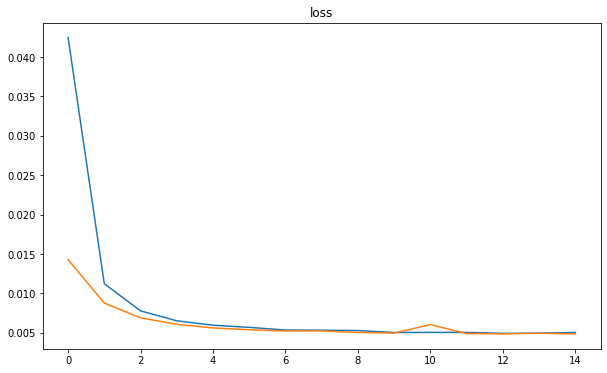

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

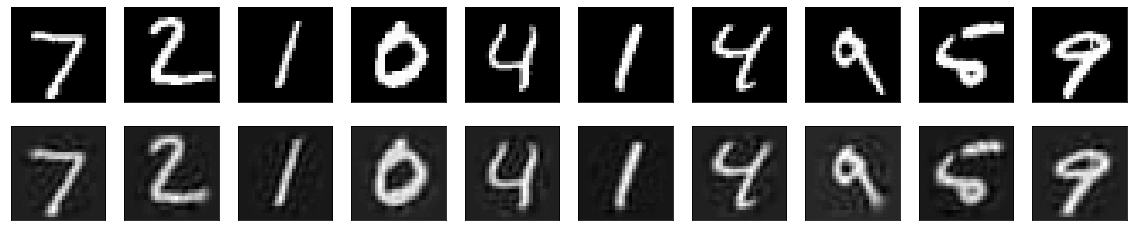

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

**Answer**

The above experiment shows the correspondance between the SVD technique and a Linear Auto Encoder architecture. Thanks to the definition of two Linear layers of the feed-forward NN, the first for encoding the images in a lower feature space (120 in our case) and the second one to decode the compressed information, we empirically see that the network has learned the PCA-SVD function by reaching aproximately the same result using the gradient descend on the mse loss function. Indeed, we can see from the table below that the loss function of the test set is almost the same, and from the above hidden neuron activiation of the encoder (prediction of the last layer) we have the same representation of the PCA-SVD result. 
This correspondance between Linear A.E and PCA has been also proved in the literature from a theoretical point of view.

|                    | Training Loss | Test loss |
|--------------------|---------------|-----------|
| PCA-SVD            | 0.00464       | 0.00455   |
| Linear Autoencoder | 0.0048        | 0.00476   |

##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1. (Insert your code and  theoretical discussion into  cells immediately below this one.)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0549 - val_loss: 0.0355
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0287 - val_loss: 0.0228
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0196 - val_loss: 0.0166
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0149 - val

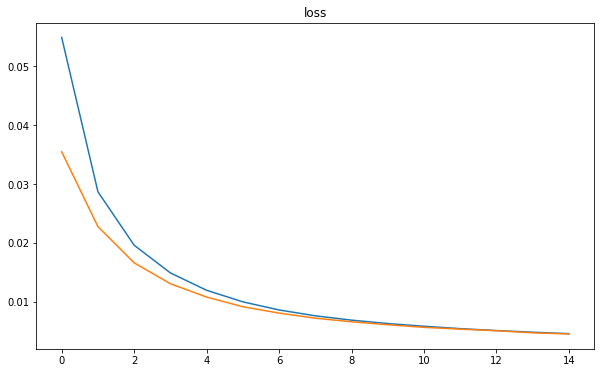

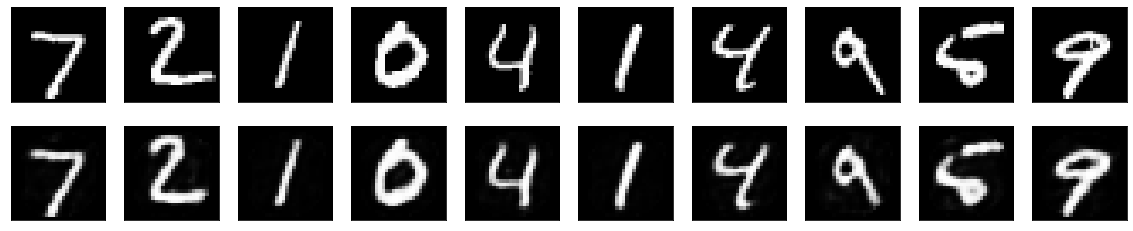

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
print(autoencoder.summary())
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, x_test, decoded_imgs)

**Answer**

Adding a non linear function like the sigmoidal function to the encoder and decoder layers helps a lot with exploring the hidden neuron representation of the layer. Empirically we see that thanks to this activation function the model is able to exploit the non-linearity property of the function to learn a better representation during ecoding and decoding. Other activations function have been tried like **Relu-Relu**, **Tanh-Tanh**, but the **sigmoidal** function resulted empirically to minimize more than the other two. Indeed the sigmoidal function guarantees a probability output for the digits. Furthermore we can see that, thanks to this configuration of Neural Network, the loss is more minimized than using the PCA-SVD approach.

|                    | Training Loss | Test loss |
|--------------------|---------------|-----------|
| PCA-SVD            | 0.00464       | 0.00455   |
| Sigmoidal A. E. | 0.0043        | 0.00419   |

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]
encoder1 = tf.keras.layers.Dense(512, activation='relu')(input_img)
encoder2 = tf.keras.layers.Dense(128, activation='selu')(encoder1)
encoder3 = tf.keras.layers.Dense(64, activation='relu')(encoder2)

decoded1 = tf.keras.layers.Dense(128, activation='relu')(encoder3)
decoded2 = tf.keras.layers.Dense(512, activation='selu')(decoded1)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded2)

autoencoder = tf.keras.models.Model(input_img, decoded)

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_131 (Dense)            (None, 512)               401920    
_________________________________________________________________
dense_132 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_133 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_134 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_135 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_136 (Dense)            (None, 784)               402

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0602 - val_loss: 0.0361
Epoch 2/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0288 - val_loss: 0.0225
Epoch 3/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0192 - val_loss: 0.0162
Epoch 4/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0131
Epoch 5/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 6/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 7/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 8/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 9/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 10/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0061
test mse: 0.00614


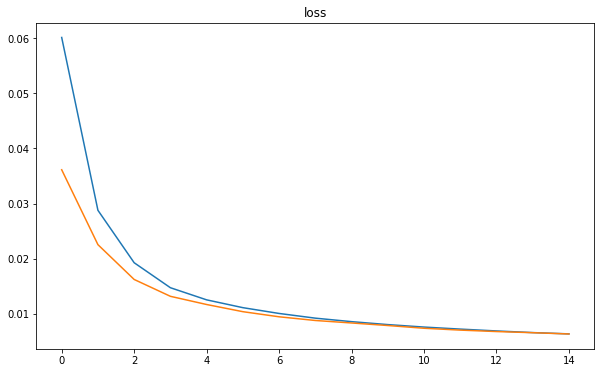

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

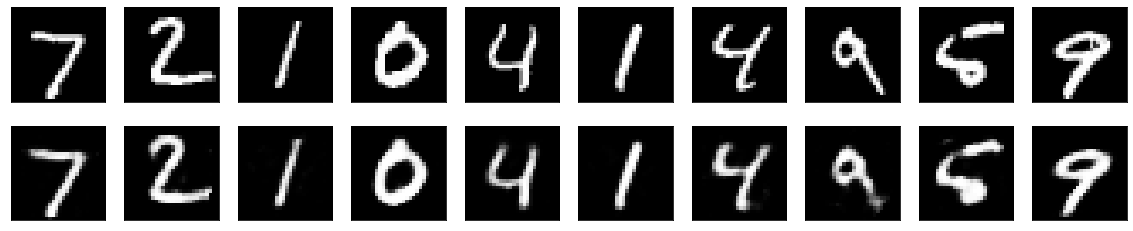

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

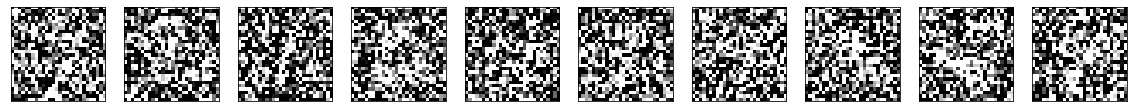

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))
#[TO COMPLETE]
encoder = tf.keras.layers.Dense(128, activation='selu')(input_img)

decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoder)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')#[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_106 (Dense)            (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0396 - val_loss: 0.0187
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0100
Epoch 3/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 4/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 5/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 6/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0947
test mse: 0.09467


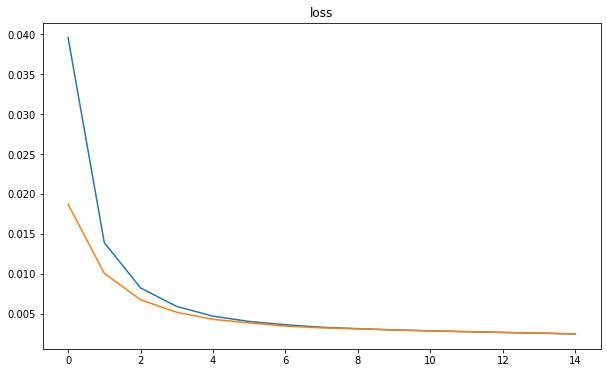

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

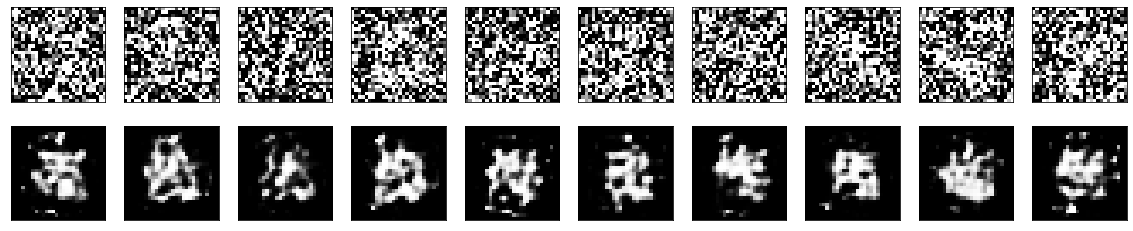

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 61ms/step - loss: 0.2345 - categorical_accuracy: 0.0912 - val_loss: 0.1221 - val_categorical_accuracy: 0.1885
Epoch 2/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0988 - categorical_accuracy: 0.2849 - val_loss: 0.0827 - val_categorical_accuracy: 0.3713
Epoch 3/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0727 - categorical_accuracy: 0.4431 - val_loss: 0.0674 - val_categorical_accuracy: 0.4853
Epoch 4/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0619 - categorical_accuracy: 0.5108 - val_loss: 0.0586 - val_categorical_accuracy: 0.5192
Epoch 5/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0543 - categorical_accuracy: 0.5438 - val_loss: 0.0514 - val_categorical_accuracy: 0.5574
Epoch 6/50
79/79 [==============================] - 5s 59ms/step - loss: 0.0473 - categorical_accuracy: 0.5744 - val_loss: 0.0464 - val_categorical_accuracy: 0.5894
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0089 - categorical_accuracy: 0.9611
categorical_accuracy: 96.11%


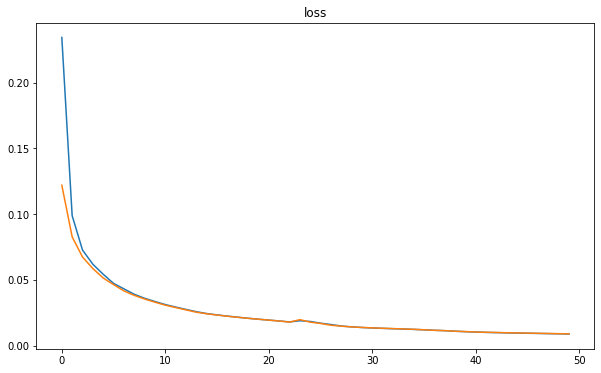

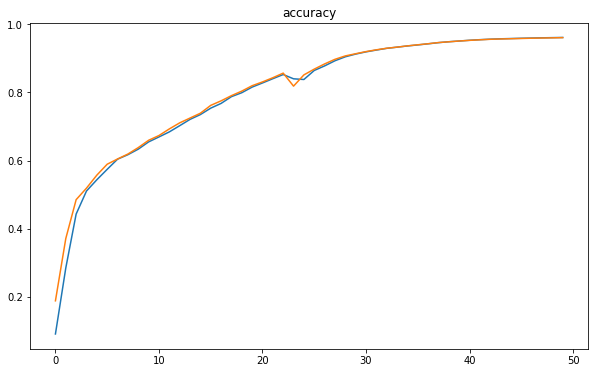

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that <oov> but that <oov> the <oov> is <oov> a very <oov> film in it about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(16, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 16)            7488      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           1700      
Total params: 9,188
Trainable params: 9,188
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 17ms/step - loss: 0.0510 - categorical_accuracy: 0.3646 - val_loss: 0.0418 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0380 - categorical_accuracy: 0.4710 - val_loss: 0.0373 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0366 - categorical_accuracy: 0.4710 - val_loss: 0.0365 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0353 - categorical_accuracy: 0.4710 - val_loss: 0.0348 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0334 - categorical_accuracy: 0.4718 - val_loss: 0.0327 - val_categorical_accuracy: 0.4862
Epoch 6/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0312 - categorical_accuracy: 0.4988 - val_loss: 0.0304 - val_categorical_accuracy: 0.4918
Epoch 7/50

40/40 - 0s - loss: 4.7257e-04 - categorical_accuracy: 0.9977
categorical_accuracy: 99.77%


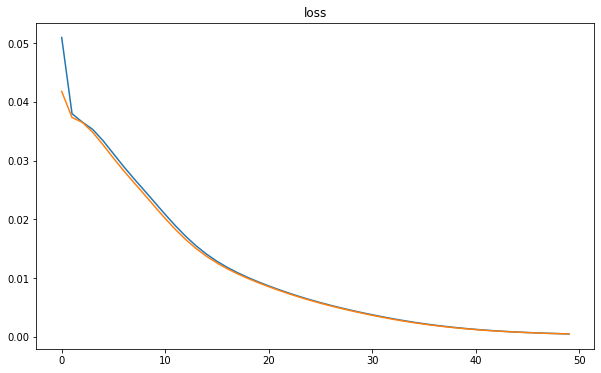

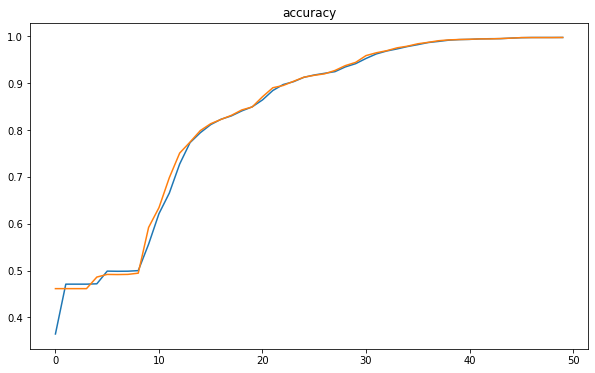

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


**Answer**

Since we want to explore a better compressed representation of the sequence information, in contrast of the previous experiment, where we used the linear function, now we exploit the effects of non linear functions during encoding and decoding. 

Note that in this case we used an LSTM model hence to make fair comparison among the models the number of units of the LSTM have to be decreased in order to have the same amount parameter complexity of the RNN. Thus 16 units reach the same amount of parameters for the SimpleRNN.
Note also that since we use less unit the total number of parameter of the model will be less in this case.

After several trials of different non linear function like: selu-sigmoid, relu-relu, sigmoid-sigmoid, tanh-tanh, sigmoid-softmax, tanh-softmax. 
We ended up that the **tanh** function for encoding and **softmax** for decoding resulted empirically to show the best performance among all the other different combinations. Indeed we are able to reach the 100 accuracy of validation set and minimize its loss function to 6.9164e-04 at the 45-46th epochs (instead the sigmoid-sofmax combination required all 50 epoch to reach the same results). Instead all the other combinations were not resulting to enhance the accuracy and minimization of the loss was stacked in a bad local minima.

Thus we can see that the non linear function helps a lot with finding a better representation of our RNN, wee need less epochs and we are able to reach a high accuracy for compressing the representation which holds more information of the linear model.

Hence for sequence based problems the A.E techniques result to be prominent to extract suitable features of the temporal dependencies which could help a supervised model to perform better and use less memory.
